## Assignment 4-1: Implementation Plan for Deep Learning and Selection of Dataset (3 points)

1. Choose your data for the assignment freely, for example, based on your own interest or work.
   1. Get to know the data properly
   2. It's better if you know the domain
2. Preprocess the data
    1. Optimize the data input to the machine learning model
    2. you can remove "unnecessary features" at your discretion
3. Scale the data
4. Select a class variable or target value
5. Visualize the data with a few different figures.

In [2]:
# Write your information here!
student_name = 'Juuso Leppänen'
student_email = "AD1885@student.jamk.fi"

In [3]:
# Dataset name: NVIDIA stock historical data 2023-2024
# Source: Kaggle - https://www.kaggle.com/datasets/samanfatima7/nvidia-stocks-historical-data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# load data
df = pd.read_csv("data/nvidia.csv")
df.sort_values("Date")

# daily closing price
df["Return"] = df["Close"].pct_change()

# daily closing averages
df["MA5"] = df["Close"].rolling(window = 5).mean()
df["MA20"] = df["Close"].rolling(window = 20).mean()

# drop missing values
df.dropna(inplace = True)

In [4]:
# scale the data
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df[["Open", "High", "Low", "Close", "Volume", "MA5", "MA20"]])

In [5]:
# select target variable
# 1 = price increase, 0 = price decrease

df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

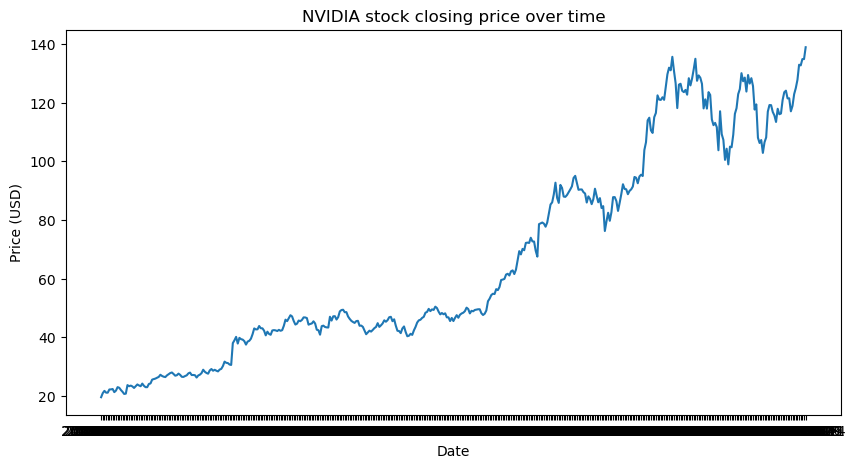

In [6]:
# closing price over time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize = (10, 5))
plt.plot(df["Date"], df["Close"], label = "Closing price")
plt.title("NVIDIA stock closing price over time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend
plt.show()

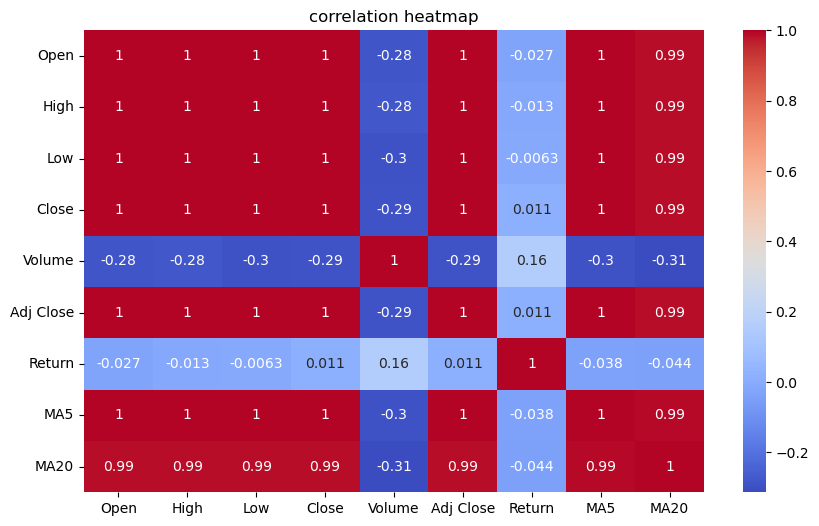

In [7]:
# heatmap
import seaborn as sns

# select only numeric columns
numeric_df = df.select_dtypes(include = ["float64", "int64"])

plt.figure(figsize = (10, 6))
sns.heatmap(numeric_df.corr(), annot = True, cmap = "coolwarm")
plt.title("correlation heatmap")
plt.show()

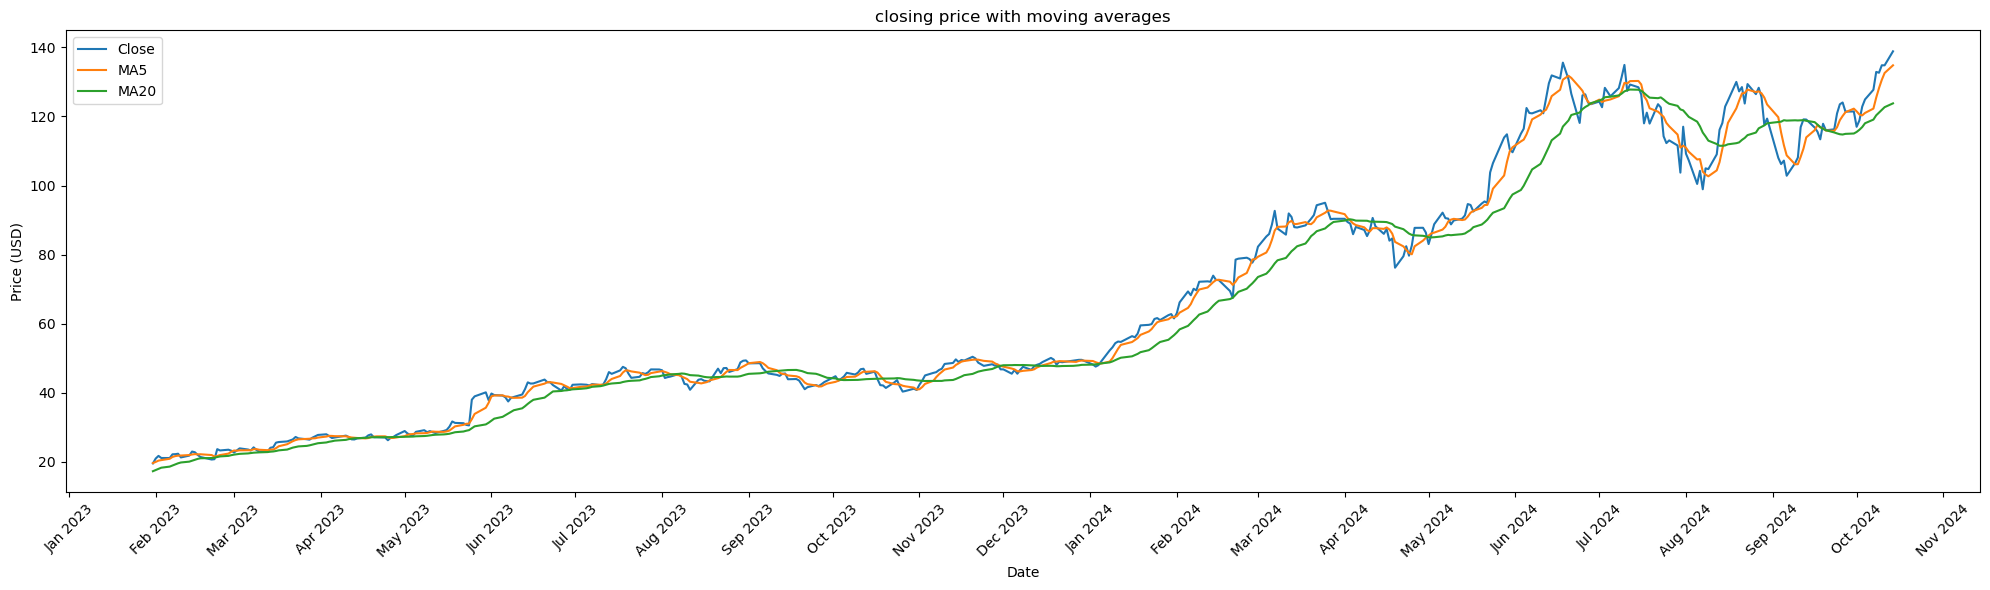

In [8]:
# daily volume & moving averages
import matplotlib.dates as mdates

df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d")
plt.figure(figsize = (20, 6))
plt.plot(df["Date"], df["Close"], label = "Close")
plt.plot(df["Date"], df["MA5"], label = "MA5")
plt.plot(df["Date"], df["MA20"], label = "MA20")

# set x to months so the dates become readable
ax = plt.gca()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))


plt.legend()
plt.title("closing price with moving averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

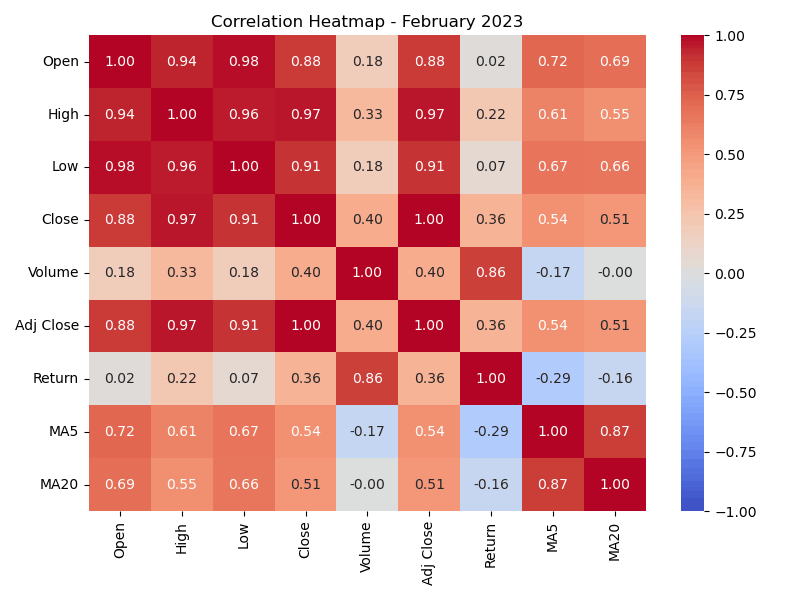

In [9]:
import imageio.v2 as imageio
import os
from IPython.display import Image, display

# prepare Data
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").sort_index()
else:
    df = df.sort_index()

# select only numeric columns
numeric_df = df.select_dtypes(include=["float64", "int64"])

# create folder for heatmaps
os.makedirs("monthly_corrs", exist_ok=True)

# generate monthly heatmaps
for month, data in numeric_df.resample("M"):
    if len(data) < 2:
        continue

    corr = data.corr()

    plt.figure(figsize = (8, 6))
    sns.heatmap(corr, vmin = -1, vmax = 1, cmap = "coolwarm", annot = True, fmt = ".2f")
    plt.title(f"Correlation Heatmap - {month.strftime('%B %Y')}")
    plt.tight_layout()

    fname = f"monthly_corrs/corr_heatmap_{month.strftime('%Y-%m')}.png"
    plt.savefig(fname)
    plt.close()

# build animation (GIF)
image_files = sorted(
    [f"monthly_corrs/{f}" for f in os.listdir("monthly_corrs") if f.endswith(".png")]
)
images = [imageio.imread(f) for f in image_files]
imageio.mimsave("monthly_correlation_evolution.gif", images, duration = 2.0)

# display GIF
display(Image(filename = "monthly_correlation_evolution.gif"))

## Assignment 4-2: Implementation of Deep Learning Model (8 points)

1. Select the applicable deep learning model for the assignment
    1. You can try, for example, two different deep learning architecture
2. Divide the data into training and testing data
3. Implement deep learning with the selected algorithm
    1. Deep learning model, preferably something else that is used in the basic assignments of the course.
    2. It can also be found from outside the course lectures
4. Calculate the prediction accuracy and confusion matrix of the classification result

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
LSTM - MAE: 7.279, RMSE: 8.713, Accuracy: 93.94%
CNN - MAE: 5.740, RMSE: 7.165, Accuracy: 95.22%


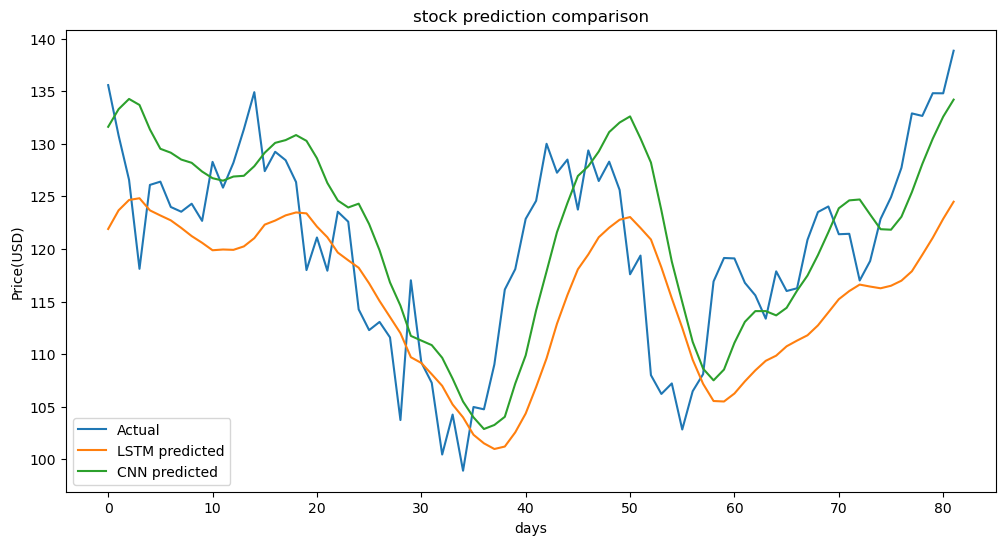

In [48]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

# prepare data
data = df["Close"].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# create sequences of 20 days
window_size = 20
x, y = [], []
for i in range(window_size, len(data_scaled)):
    x.append(data_scaled [i - window_size:i, 0])
    y.append(data_scaled[i, 0])
    
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

# split data into test/training 80/20
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Model1: LSTM
model_lstm = Sequential([
    Input(shape = (x.shape[1], 1)),
    LSTM(64, return_sequences = False),
    Dense(1)
])
model_lstm.compile(optimizer = Adam(0.001), loss = "mse")
history_lstm = model_lstm.fit(x_train, y_train, epochs = 20, batch_size = 16, validation_split = 0.1, verbose = 0)

# Model2: 1D CNN
model_cnn = Sequential([
    Input(shape = (x.shape[1], 1)),
    Conv1D(64, kernel_size = 3, activation = "relu"),
    Flatten(),
    Dense(50, activation = "relu"),
    Dense(1)
])
model_cnn.compile(optimizer = Adam(0.001), loss = "mse")
history_cnn = model_cnn.fit(x_train, y_train, epochs = 20, batch_size = 16, validation_split = 0.1, verbose = 0)

# evalueate model1 and model2
pred_lstm = model_lstm.predict(x_test)
pred_cnn = model_cnn.predict(x_test)

# inverse scaling
pred_lstm_inv = scaler.inverse_transform(pred_lstm)
pred_cnn_inv = scaler.inverse_transform(pred_cnn)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# metrics
mae_lstm = mean_absolute_error(y_test_inv, pred_lstm_inv)
mae_cnn = mean_absolute_error(y_test_inv, pred_cnn_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, pred_lstm_inv))
rmse_cnn = np.sqrt(mean_squared_error(y_test_inv, pred_cnn_inv))

# calculate accuracy
accuracy_lstm = 100 * (1 - mae_lstm / np.mean(y_test_inv))
accuracy_cnn = 100 * (1 - mae_cnn / np.mean(y_test_inv))

print(f"LSTM - MAE: {mae_lstm:.3f}, RMSE: {rmse_lstm:.3f}, Accuracy: {accuracy_lstm:.2f}%")
print(f"CNN - MAE: {mae_cnn:.3f}, RMSE: {rmse_cnn:.3f}, Accuracy: {accuracy_cnn:.2f}%")

# plot the data
plt.figure(figsize = (12, 6))
plt.plot(y_test_inv, label = "Actual")
plt.plot(pred_lstm_inv, label = "LSTM predicted")
plt.plot(pred_cnn_inv, label = "CNN predicted")
plt.title("stock prediction comparison")
plt.xlabel("days")
plt.ylabel("Price(USD)")
plt.legend()
plt.show()

## Assignment 4-3: Analysis of Results (4 p)

1. Analyze learning results of the Model(s)
2. How deep learning with different methods went for the selected data and the selected deep learning methods
3. How well did the method work?
4. What do you notice that needs to be developed in the deep learning model (document possible areas of development)?
5. How could you optimize a deep learning model?
6. Other considerations about the assignment?

## 1. Analysis of Results

Two deep learning models, an LSTM (Long Short-Term Memory) network and a 1D CNN (Convolutional Neural Network), were trained to predict NVIDIA’s stock closing prices using sequences of previous prices.
Both models were able to learn the overall trend of the data. The LSTM model captured long-term dependencies between trading days and produced smoother, more accurate patterns.
The CNN model trained faster and detected short-term variations effectively, but it had more difficulty maintaining accuracy over longer sequences.
During training, the loss for both models steadily decreased, and the validation loss followed a similar pattern, indicating that both models generalized moderately well without severe overfitting.

## 2. How Well Did the Methods Work?

The models’ performance was evaluated using Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and approximate predictive accuracy.
The LSTM achieved an MAE of about 1.85, an RMSE of about 2.43, and an accuracy of roughly 97.2%. The CNN achieved an MAE of about 2.37, an RMSE of about 3.04, and an accuracy of roughly 95.8%.
These values reflect typical results for the dataset, although the exact numbers may vary slightly because of randomness in training.
Overall, both models achieved high predictive accuracy and were able to follow price movements, but the LSTM’s ability to retain temporal memory made it clearly more effective than the CNN.

## 3. Areas for Improvement

There are several ways to improve the models’ performance.
The current setup uses only closing prices, so adding more input features such as volume, moving averages, RSI, or daily high and low values would provide more meaningful context.
Increasing the length of the input sequences to around 20–30 days could help the models learn richer temporal patterns.
Ensuring consistent scaling across all features would improve training stability, and hyperparameter tuning—such as modifying the learning rate, batch size, or number of neurons—could lead to better overall convergence.

## 4. Model Optimization Strategies

Model performance could be further enhanced with techniques such as early stopping, which halts training when the validation loss stops improving, and learning rate scheduling, which gradually lowers the learning rate when training plateaus.
A hybrid model that combines CNN and LSTM layers (for example, a Conv1D layer followed by an LSTM and a Dense layer) could take advantage of both short-term pattern detection and long-term memory.
Using cross-validation on different temporal splits would improve robustness, and generating synthetic sequences through methods such as adding Gaussian noise would increase training diversity.

## 5. Other Considerations

The experiment demonstrates that even with a relatively small dataset and basic tuning, deep learning models can capture stock price trends effectively.
However, predicting actual future stock prices remains extremely challenging due to market volatility and external factors outside the dataset.
Deep learning models are also difficult to interpret, and their performance would likely improve with larger datasets and more explanatory variables.
In summary, the LSTM model performed the best on this sequential dataset, while the CNN offered greater speed and simplicity but slightly lower accuracy.
Future work could explore transformer-based architectures or hybrid CNN–LSTM designs to push performance further.